In [1]:
import pandas as pd
import matplotlib as plt

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
query_frame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Query.csv',sep=";")
#train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic+Data.csv', sep = ";", decimal=',')
query_frame

,count(event),hour_,Unnamed: 2,Unnamed: 3
0,51,09.06.2022 18:00,NaN,NaN
1,185,09.06.2022 19:00,NaN,NaN
2,136,09.06.2022 20:00,NaN,NaN
3,132,09.06.2022 21:00,NaN,NaN
4,93,09.06.2022 22:00,NaN,NaN
...,...,...,...,...
1249,72,31.07.2022 19:00,NaN,NaN
1250,66,31.07.2022 20:00,NaN,NaN
1251,53,31.07.2022 21:00,NaN,NaN
1252,56,31.07.2022 22:00,NaN,NaN


In [5]:
query_frame=query_frame.drop(columns=['Unnamed: 2'], axis=1)
query_frame=query_frame.drop(columns=['Unnamed: 3'], axis=1)

In [6]:
query_frame=query_frame[6:]

In [7]:
query_frame

,count(event),hour_
6,56,10.06.2022 0:00
7,27,10.06.2022 1:00
8,25,10.06.2022 2:00
9,24,10.06.2022 3:00
10,20,10.06.2022 4:00
...,...,...
1249,72,31.07.2022 19:00
1250,66,31.07.2022 20:00
1251,53,31.07.2022 21:00
1252,56,31.07.2022 22:00


In [8]:
#query_frame = pd.read_csv('New_Query.txt')

In [9]:
main_data = query_frame['count(event)'].values.astype(float)

In [10]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 25
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

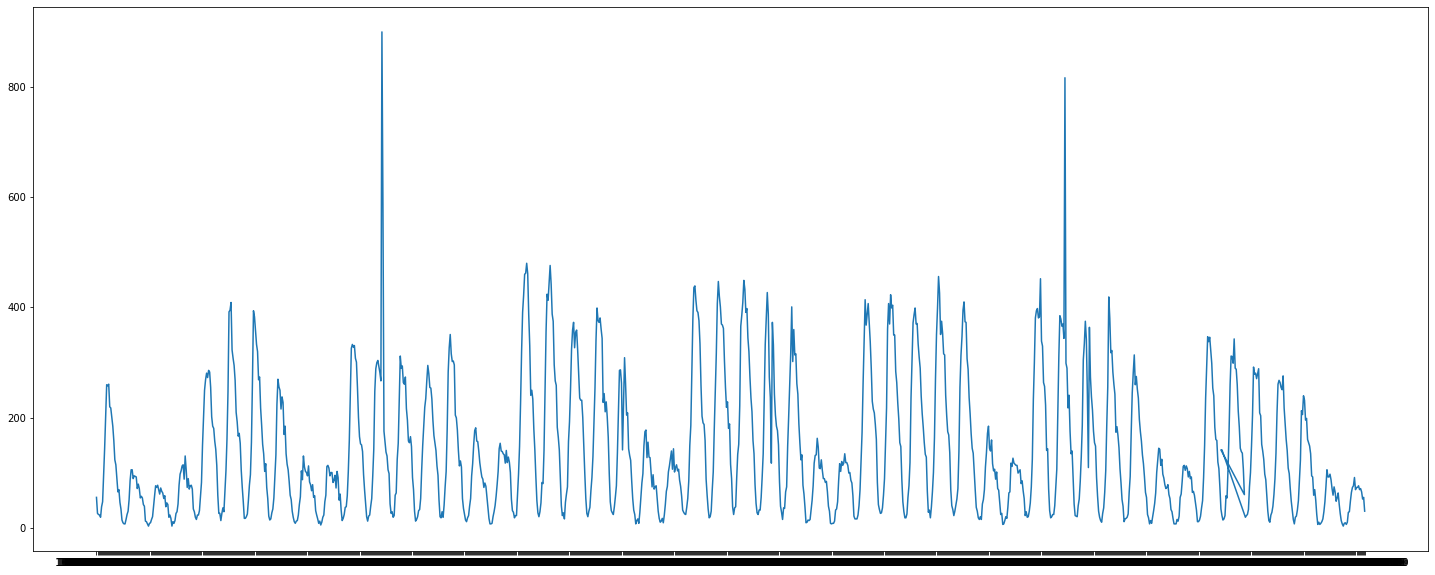

In [11]:
x = query_frame['hour_']
y = query_frame['count(event)'] 
plt.plot(x, y)
plt.show()

In [ ]:
# Подготавливаем тестовые и трернировочне данные

In [40]:
window_size = 24

train_data = main_data[:-window_size]
test_data = main_data[-window_size:]


In [13]:
print(len(train_data))
print(len(test_data))

1224
24


In [14]:
print(test_data)

[14.  8.  4.  9. 10.  7. 11. 29. 30. 49. 65. 74. 77. 92. 70. 74. 74. 77.
 70. 72. 66. 53. 56. 31.]


In [15]:
# нормализация
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(-1, 1))
y = y.values.reshape(-1,1)
train_data_normalized = scaler.fit_transform(y)

In [16]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized

tensor([-0.8838, -0.9486, -0.9531,  ..., -0.8905, -0.8838, -0.9397])

In [17]:

# функция для создания кортежей из 24 элементов
def window(data, nw):
    sequences=[]
    length_seq=len(data)
    for i in range(length_seq-nw):
        train_seq = data[i:i+nw]
        train_mark = data[i+nw:i+nw+1]
        sequences.append((train_seq, train_mark))
    return sequences

In [18]:
# создаём последовательности
train_sequences = window(train_data_normalized,window_size)

In [19]:
train_sequences[:2]

[(tensor([-0.8838, -0.9486, -0.9531, -0.9553, -0.9642, -0.9218, -0.9017, -0.7989,
          -0.6849, -0.5553, -0.4279, -0.4324, -0.4257, -0.5173, -0.5218, -0.5575,
          -0.5955, -0.6536, -0.7318, -0.7520, -0.8078, -0.8615, -0.8525, -0.9039]),
  tensor([-0.9307])),
 (tensor([-0.9486, -0.9531, -0.9553, -0.9642, -0.9218, -0.9017, -0.7989, -0.6849,
          -0.5553, -0.4279, -0.4324, -0.4257, -0.5173, -0.5218, -0.5575, -0.5955,
          -0.6536, -0.7318, -0.7520, -0.8078, -0.8615, -0.8525, -0.9039, -0.9307]),
  tensor([-0.9754]))]

In [20]:
# LSTM
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size)) # (num_layers * num_directions, batch_size, hidden_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [21]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
# обучение модели

In [23]:
epochs = 10

for i in range(epochs):
    for seq, labels in train_sequences:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00128694
epoch:   1 loss: 0.00021467
epoch:   2 loss: 0.00266325
epoch:   3 loss: 0.00352179
epoch:   4 loss: 0.00387933
epoch:   5 loss: 0.00373162
epoch:   6 loss: 0.00365973
epoch:   7 loss: 0.00327014
epoch:   8 loss: 0.00272263
epoch:   9 loss: 0.00251898
epoch:   9 loss: 0.0025189794


In [24]:
preds= 24
test_inputs=train_data_normalized[-window_size:].tolist()

In [25]:
test_inputs

[-0.9776536226272583,
 -0.9910614490509033,
 -1.0,
 -0.9888268113136292,
 -0.986592173576355,
 -0.9932960867881775,
 -0.9843575358390808,
 -0.9441340565681458,
 -0.9418994188308716,
 -0.8994413614273071,
 -0.8636871576309204,
 -0.8435754179954529,
 -0.8368715047836304,
 -0.8033519387245178,
 -0.8525139689445496,
 -0.8435754179954529,
 -0.8435754179954529,
 -0.8368715047836304,
 -0.8525139689445496,
 -0.8480446934700012,
 -0.8614525198936462,
 -0.8905028104782104,
 -0.8837988972663879,
 -0.9396647810935974]

In [26]:
test_data

array([14.,  8.,  4.,  9., 10.,  7., 11., 29., 30., 49., 65., 74., 77.,
       92., 70., 74., 74., 77., 70., 72., 66., 53., 56., 31.])

In [27]:
win=24

In [28]:
model.eval()

for i in range(len(test_data)):
    seq = torch.FloatTensor(test_inputs[-win:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [29]:
test_inputs[win:]

[-0.9532026648521423,
 -0.9706367254257202,
 -0.9824923276901245,
 -0.9914165735244751,
 -0.9970535635948181,
 -0.998712956905365,
 -0.9958479404449463,
 -0.9879106283187866,
 -0.9744935035705566,
 -0.956227719783783,
 -0.933762788772583,
 -0.9084650278091431,
 -0.8821272850036621,
 -0.8567239046096802,
 -0.8338789343833923,
 -0.8155342936515808,
 -0.8026384115219116,
 -0.7957050800323486,
 -0.7946325540542603,
 -0.7991036772727966,
 -0.8083478212356567,
 -0.8216252326965332,
 -0.838306188583374,
 -0.8574751615524292]

In [30]:
test_inputs[:win]

[-0.9776536226272583,
 -0.9910614490509033,
 -1.0,
 -0.9888268113136292,
 -0.986592173576355,
 -0.9932960867881775,
 -0.9843575358390808,
 -0.9441340565681458,
 -0.9418994188308716,
 -0.8994413614273071,
 -0.8636871576309204,
 -0.8435754179954529,
 -0.8368715047836304,
 -0.8033519387245178,
 -0.8525139689445496,
 -0.8435754179954529,
 -0.8435754179954529,
 -0.8368715047836304,
 -0.8525139689445496,
 -0.8480446934700012,
 -0.8614525198936462,
 -0.8905028104782104,
 -0.8837988972663879,
 -0.9396647810935974]

In [31]:
actual_predictions= scaler.inverse_transform(np.array(test_inputs[win:]).reshape(-1,1))

In [32]:
real_meanings = scaler.inverse_transform(np.array(test_inputs[:win]).reshape(-1,1))

In [33]:
pred_meanings =actual_predictions

In [34]:
fig_size2 = plt.rcParams["figure.figsize"]
fig_size2[0] = 25
fig_size2[1] = 10
plt.rcParams["figure.figsize"] = fig_size2

In [35]:
test_data

array([14.,  8.,  4.,  9., 10.,  7., 11., 29., 30., 49., 65., 74., 77.,
       92., 70., 74., 74., 77., 70., 72., 66., 53., 56., 31.])

In [36]:
query_frame['hour_'][-24:]

1230     31.07.2022 0:00
1231     31.07.2022 1:00
1232     31.07.2022 2:00
1233     31.07.2022 3:00
1234     31.07.2022 4:00
1235     31.07.2022 5:00
1236     31.07.2022 6:00
1237     31.07.2022 7:00
1238     31.07.2022 8:00
1239     31.07.2022 9:00
1240    31.07.2022 10:00
1241    31.07.2022 11:00
1242    31.07.2022 12:00
1243    31.07.2022 13:00
1244    31.07.2022 14:00
1245    31.07.2022 15:00
1246    31.07.2022 16:00
1247    31.07.2022 17:00
1248    31.07.2022 18:00
1249    31.07.2022 19:00
1250    31.07.2022 20:00
1251    31.07.2022 21:00
1252    31.07.2022 22:00
1253    31.07.2022 23:00
Name: hour_, dtype: object

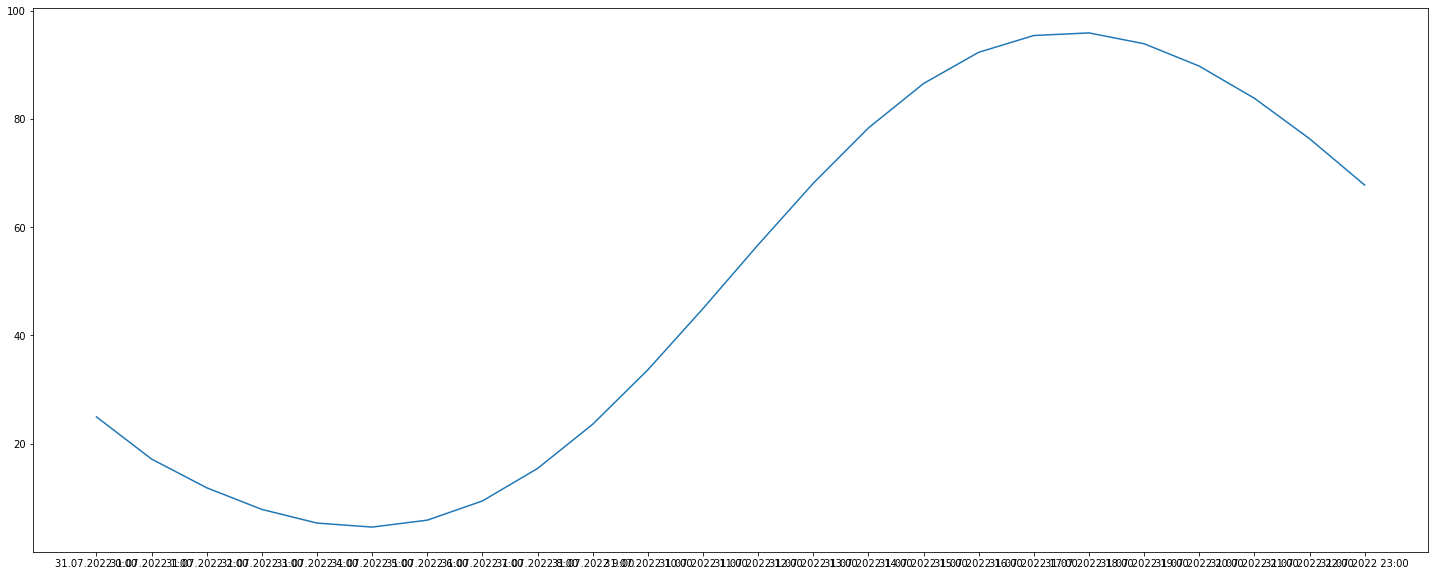

In [37]:
x = query_frame['hour_'][-win:]
y = pred_meanings
plt.plot(x, y)
plt.show()

In [38]:
y[0]

array([24.94180748])

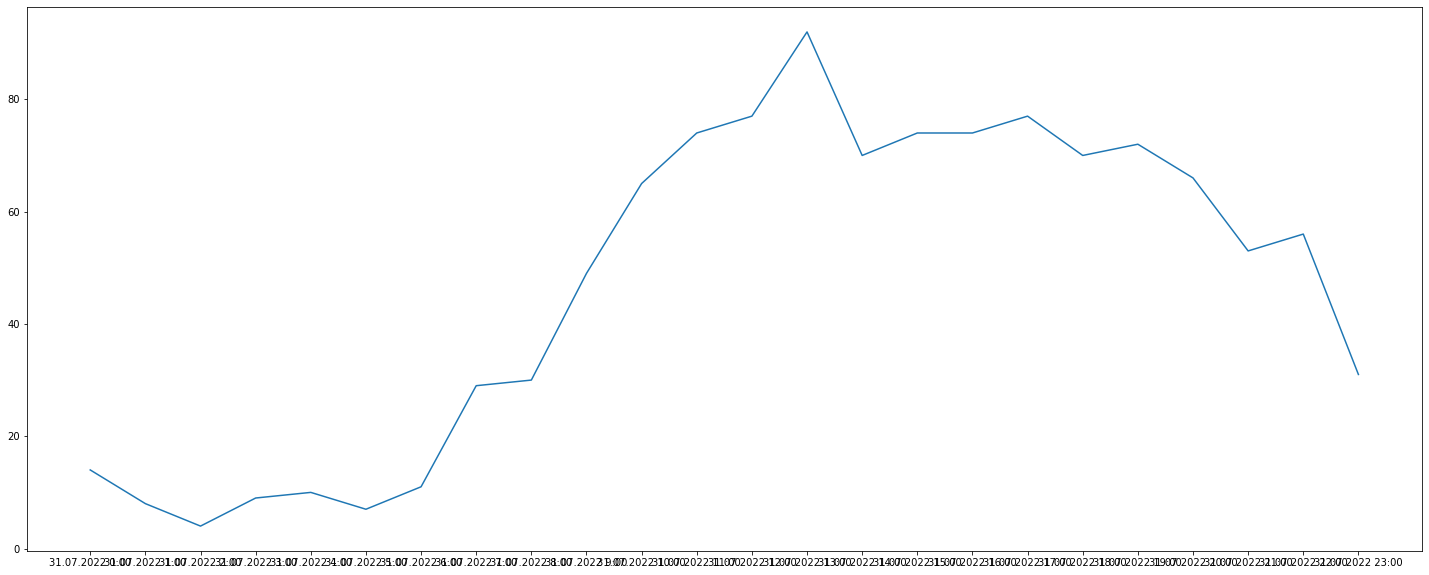

In [39]:
x2 = query_frame['hour_'][-win:]
y2 = query_frame['count(event)'][-win:]
plt.plot(x2, y2)
plt.show()

In [ ]:
import torch.nn as nn

class RNN_LSTM_Base(nn.Module):
    def training_step(self, batch):
        samples, targets = batch
        outputs = self(samples.double())
        loss = nn.functional.mse_loss(outputs, targets)
        return loss

class VanillaRNN(RNN_LSTM_Base):
    def __init__(self, in_size=24, hid_size_rnn=100, hid_size_lin=100, out_size=24, n_layers=1):
        super(VanillaRNN, self).__init__()
        # Определяем размерность слоев
        self.input_size = in_size
        self.hidden_size_rnn = hid_size_rnn
        self.hidden_size_lin = hid_size_lin
        self.output_size = out_size
        self.n_layers = n_layers
        # Опредляем RNN слой
        self.rnn = nn.RNN(in_size, hid_size_rnn, n_layers, batch_first=True)
        # Определяем линейный слой
        self.linear = nn.Linear(hid_size_lin, out_size)

    def forward(self, x):
        # x должен быть размера (batch_size, seq_len, input_size)
        xb = x.view(x.size(0), x.size(1), self.input_size).double()
        # Initialize the hidden layer's array of shape (n_layers*n_dirs, batch_size, hidden_size_rnn)
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size_rnn, requires_grad=True).double()
        # out is of shape (batch_size, seq_len, num_dirs*hidden_size_rnn)
        out, hn = self.rnn(xb, h0)
        # out needs to be reshaped into dimensions (batch_size, hidden_size_lin)
        out = out.reshape(x.size(0), self.hidden_size_lin)
        out = nn.functional.relu(out)
        # Finally we get out in the shape (batch_size, output_size)
        out = self.linear(out)
        return out

In [ ]:
def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        model.train()
        for batch in train_loader:
            loss = model.training_step(batch)
            # Calculate gradients from chain rule
            loss.backward()
            # Apply gradient descent step
            optimizer.step()
            # Remove gradients for next iteration
            optimizer.zero_grad()
    return 'Trained for {} epochs'.format(epochs) 